In [1]:

from model_track.binning import (
    BinApplier,
    TreeBinner,
    QuantileBinner
)

from model_track.woe import (
    WoeCalculator,
    WoeByPeriod
)
from model_track.stats import (
    get_summary
)
from model_track.stability.woe import (
    WoeStability
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)

n_per_period = 50
periods = ["2024-01", "2024-02", "2024-03", "2024-04"]

rows = []

for period in periods:
    idade = np.random.normal(loc=40, scale=12, size=n_per_period).clip(18, 75)
    renda = np.random.lognormal(mean=8.2, sigma=0.5, size=n_per_period)

    # ----- introduzindo missing -----
    idade[np.random.rand(n_per_period) < 0.05] = np.nan
    renda[np.random.rand(n_per_period) < 0.05] = np.nan

    # ----- probabilidade do evento (default, fraude, etc.) -----
    prob_event = (
        0.15
        + 0.002 * (idade < 25)
        + 0.003 * (idade > 60)
        + 0.004 * (renda < 2500)
    )

    prob_event = np.clip(prob_event, 0.02, 0.7)

    vr = np.random.binomial(1, prob_event)

    rows.append(
        pd.DataFrame(
            {
                "idade": idade,
                "renda": renda,
                "vr": vr,
                "period": period,
            }
        )
    )

df = pd.concat(rows, ignore_index=True)
df["period"] = pd.to_datetime(df["period"], format="%Y-%m")
# ----- Summary inicial -----
df_summary = get_summary(df=df)
df_summary


,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,idade,float64,5,2.5,18.0,4.615385,188,...,18.0,70.880318
1,renda,float64,12,6.0,4281.428458,0.531915,189,...,982.52663,16974.040121
2,vr,int64,0,0.0,0,76.000000,2,"[0, 1]",0,1
3,period,datetime64[ns],0,0.0,2024-01-01 00:00:00,25.000000,4,"[2024-01-01 00:00:00, 2024-02-01 00:00:00, 202...",2024-01-01 00:00:00,2024-04-01 00:00:00


In [3]:
# ----- Binning supervisionado -----
features = ["renda", "idade"]
target = "vr"


binner = TreeBinner(
    max_depth=2,
    min_samples_leaf=1
)
binner.fit(df, feature='renda', target=target)
bins = binner.bins_
bins = [round(b, 2) for b in bins]
applier = BinApplier(df)
df[f"{'renda'}_cat"] = applier.apply('renda', bins)

binner = QuantileBinner(n_bins=3)
binner.fit(df, feature='idade')
bins = binner.bins_
bins = [round(b, 2) for b in bins]
applier = BinApplier(df)
df[f"{'idade'}_cat"] = applier.apply('idade', bins)

# ----- Tratamento explícito de missing pós-binning -----
for feature in features:
    df[f"{feature}_cat"] = (
        df[f"{feature}_cat"]
        .astype("object")
        .fillna("N/A")
    )

# ----- Summary após binning -----
get_summary(df=df)


,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,idade,float64,5,2.5,18.0,4.615385,188,...,18.0,70.880318
1,renda,float64,12,6.0,4281.428458,0.531915,189,...,982.52663,16974.040121
2,vr,int64,0,0.0,0,76.000000,2,"[0, 1]",0,1
3,period,datetime64[ns],0,0.0,2024-01-01 00:00:00,25.000000,4,"[2024-01-01 00:00:00, 2024-02-01 00:00:00, 202...",2024-01-01 00:00:00,2024-04-01 00:00:00
4,renda_cat,object,0,0.0,"(2398.17, 5940.57]",63.000000,5,"[(2398.17, 5940.57], (5940.57, 7826.71], <= 23...",None,None
5,idade_cat,object,0,0.0,> 44.54,32.500000,4,"[> 44.54, (34.06, 44.54], <= 34.06, N/A]",None,None


In [4]:
woe_tables = {}

for feature in features:
    woe_table = WoeCalculator.compute_table(
        df=df,
        target_col=target,
        feature_col=f"{feature}_cat",
        event_value=1,
        add_totals=True,
    )



    print(f"\nWOE / IV — {feature.upper()}")
    display(woe_table)



WOE / IV — RENDA


,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,"(5940.57, 7826.71]",10,6,0.2083,0.0395,0.080,1.6635,0.2809,0.4828
1,N/A,4,8,0.0833,0.0526,0.060,0.4595,0.0141,0.4828
2,"(2398.17, 5940.57]",29,97,0.6042,0.6382,0.630,-0.0547,0.0019,0.4828
3,> 7826.71,2,9,0.0417,0.0592,0.055,-0.3514,0.0062,0.4828
4,<= 2398.17,3,32,0.0625,0.2105,0.175,-1.2144,0.1798,0.4828
5,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.4828,0.4828



WOE / IV — IDADE


,idade_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,N/A,2,3,0.0417,0.0197,0.025,0.7472,0.0164,0.0378
1,"(34.06, 44.54]",17,48,0.3542,0.3158,0.325,0.1147,0.0044,0.0378
2,<= 34.06,16,49,0.3333,0.3224,0.325,0.0334,0.0004,0.0378
3,> 44.54,13,52,0.2708,0.3421,0.325,-0.2336,0.0167,0.0378
4,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.0378,0.0378


In [5]:
# ----- Exemplo de mapeamento WOE -----
woe_mapping_renda = WoeCalculator.compute_mapping(
    df=df,
    target_col=target,
    feature_col="renda_cat",
)

woe_mapping_renda

{'(5940.57, 7826.71]': 1.6635,
 'N/A': 0.4595,
 '(2398.17, 5940.57]': -0.0547,
 '> 7826.71': -0.3514,
 '<= 2398.17': -1.2144}

In [6]:
df_result = WoeByPeriod.compute(
        df=df,
        target_col='vr',
        feature_col="renda_cat",
        date_col="period",
    )

df_result

,period,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,2024-01-01,"(5940.57, 7826.71]",2,2,0.1538,0.0541,0.08,1.0460,0.1044,inf
1,2024-01-01,"(2398.17, 5940.57]",10,26,0.7692,0.7027,0.72,0.0905,0.0060,inf
2,2024-01-01,<= 2398.17,1,5,0.0769,0.1351,0.12,-0.5635,0.0328,inf
3,2024-01-01,> 7826.71,0,2,0.0000,0.0541,0.04,-inf,inf,inf
4,2024-01-01,N/A,0,2,0.0000,0.0541,0.04,-inf,inf,inf
5,2024-02-01,N/A,3,1,0.2500,0.0263,0.08,2.2513,0.5036,inf
6,2024-02-01,> 7826.71,1,1,0.0833,0.0263,0.04,1.1527,0.0657,inf
7,2024-02-01,"(5940.57, 7826.71]",1,2,0.0833,0.0526,0.06,0.4595,0.0141,inf
8,2024-02-01,"(2398.17, 5940.57]",7,28,0.5833,0.7368,0.70,-0.2336,0.0359,inf
9,2024-02-01,<= 2398.17,0,6,0.0000,0.1579,0.12,-inf,inf,inf


,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,"(5940.57, 7826.71]",10,6,0.2083,0.0395,0.080,1.6635,0.2809,0.4828
1,N/A,4,8,0.0833,0.0526,0.060,0.4595,0.0141,0.4828
2,"(2398.17, 5940.57]",29,97,0.6042,0.6382,0.630,-0.0547,0.0019,0.4828
3,> 7826.71,2,9,0.0417,0.0592,0.055,-0.3514,0.0062,0.4828
4,<= 2398.17,3,32,0.0625,0.2105,0.175,-1.2144,0.1798,0.4828
5,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.4828,0.4828


<Axes: title={'center': 'WOE Stability Over Time — idade_cat'}, xlabel='Period', ylabel='WOE'>

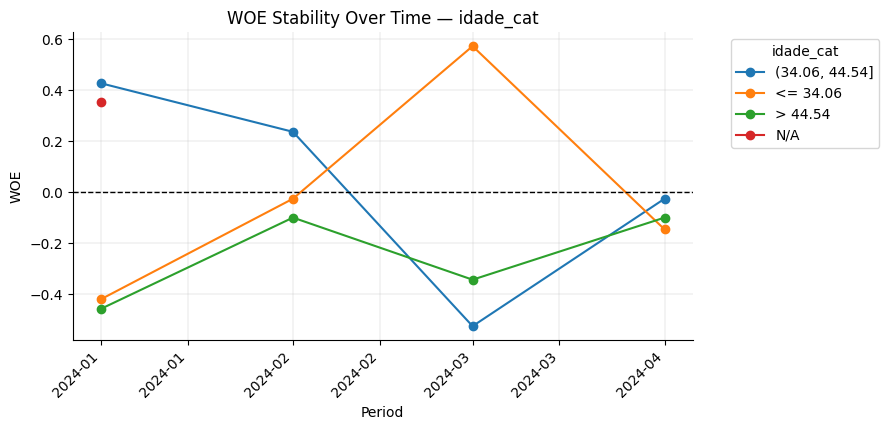

In [7]:
ws = WoeStability(df=df, date_col="period")

global_woe = ws.global_table(
    feature_col="renda_cat",
    target_col="vr",
)


# tabela global
global_woe = ws.global_table(
    feature_col="renda_cat",
    target_col="vr",
)
display(global_woe)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col="idade_cat",
    target_col="vr",
    ax=ax,
)